In [1]:
import itertools
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

from time import time
from glob import glob
from keras.preprocessing import image
from pathlib import Path
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tqdm import tqdm
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


In [2]:
root_directory=os.path.dirname(os.path.abspath(''))
training_data_directory=os.path.join(root_directory, 'training', 'data');
test_data_directory=os.path.join(training_data_directory, 'split', 'test_data')
model_directory=os.path.join(root_directory, 'models')

class_names=[]
with open(model_directory + '/labels.txt') as file:
    class_names=file.readlines()
    class_names=[line.rstrip() for line in class_names]

image_size=(224, 224)

If you get following error message while loading model:
```
OSError: SavedModel file does not exist at: /var/folders/.../tfhub_modules/{hash}/{saved_model.pbtxt|saved_model.pb}
```
try to remove model cache
```
rm -rf /var/folders/.../tfhub_modules/{hash}/
```

In [3]:
model = load_model(model_directory, custom_objects={'KerasLayer':hub.KerasLayer}, compile=False)
model_weight = os.path.join(model_directory, "saved_model_weights.h5")
if os.path.exists(model_weight):
    print("Loading existing weights for fine-tuning")
    model.load_weights(model_weight)

model.summary()

Loading existing weights for fine-tuning
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
_________________________________________________________________
prediction (Activation)      (None, 2)                 0         
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [4]:
x_test=[]
y_test=[]
image_paths=[]

t0=time()
image_files=glob(pathname=os.path.join(test_data_directory, "**/*.jpg"))
for image_file in tqdm(image_files):
        # Load the current image file
        image_data = image.load_img(
            image_file,
            target_size=image_size,
            interpolation='bicubic'
        )

        # Convert the loaded image file to a numpy array
        image_array = image.img_to_array(image_data)
        image_array /= 255

        # Add to list of test images
        x_test.append(image_array)

        # Now add answer derived from folder
        path_name = os.path.dirname(image_file)
        folder_name = os.path.basename(path_name)
        y_test.append(class_names.index(folder_name))
        image_paths.append(image_file)

print('Image loaded in {:.3f}s'.format(time() - t0))

100%|██████████| 7498/7498 [00:58<00:00, 128.79it/s]

Image loaded in 58.332s


In [5]:
t0 = time()

print('Calculating predictions...')
x_test = np.array(x_test)

predictions = model.predict(x_test)
y_pred = np.argmax(predictions, axis=1)
print('Prediction done in {:.3f}s'.format(time() - t0))


Calculating predictions...
Prediction done in 193.993s


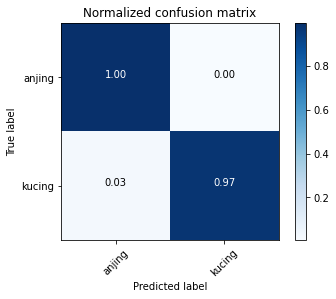

              precision    recall  f1-score   support

      anjing       0.98      1.00      0.99      3749
      kucing       1.00      0.97      0.99      3749

    accuracy                           0.99      7498
   macro avg       0.99      0.99      0.99      7498
weighted avg       0.99      0.99      0.99      7498



In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          tight_layout=False,
                          cmap=plt.cm.get_cmap('Blues')):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if tight_layout:
        plt.tight_layout()

# Plot normalized confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

print(classification_report(y_test, y_pred, target_names=class_names))


In [7]:
def predict_images(filename):
    loaded_images = []
    img = keras.preprocessing.image.load_img(
        filename,
        target_size=image_size,
        interpolation='bicubic'
    )

    img_array = keras.preprocessing.image.img_to_array(img)
    plt.axis('off')
    plt.imshow(img)
    img_array /= 255
    loaded_images.append(img_array)

    predictions = model.predict(np.asarray(loaded_images))
    probs = []
    for i, single_preds in enumerate(predictions):
        single_probs = {}
        for j, pred in enumerate(single_preds):
            single_probs[class_names[j]] = '{:.2f}%'.format(float(pred) * 100)
        probs.append(single_probs)

    print(probs)

#predict_images("/Users/anggara.t.setiawan/Documents/Work/sites/nsfw-model/training/data/processed/sensitive/sensitive_329.jpg")
predict_images("/Users/anggara.t.setiawan/Documents/Work/sites/nsfw-model/training/data/processed/sensitive/sensitive_1384.jpg")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/anggara.t.setiawan/Documents/Work/sites/nsfw-model/training/data/processed/sensitive/sensitive_1384.jpg'

kucing_10350.jpg -> anjing: 55.66%


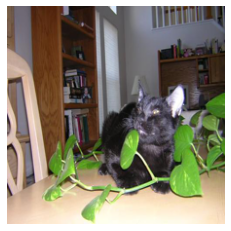

kucing_550.jpg -> anjing: 74.47%


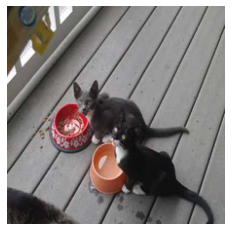

kucing_3314.jpg -> anjing: 56.63%


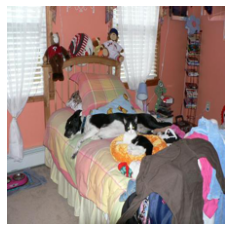

kucing_9836.jpg -> anjing: 52.98%


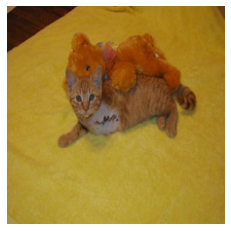

kucing_10769.jpg -> anjing: 95.31%


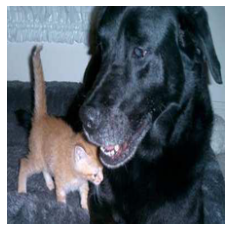

kucing_1701.jpg -> anjing: 51.86%


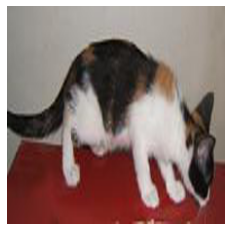

kucing_427.jpg -> anjing: 56.06%


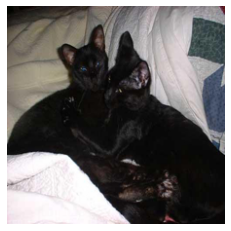

kucing_2395.jpg -> anjing: 80.28%


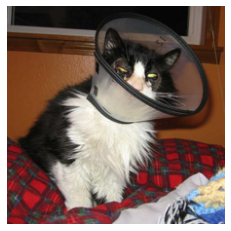

kucing_1677.jpg -> anjing: 51.71%


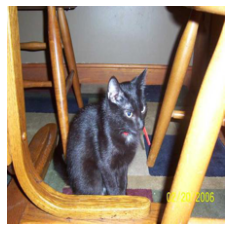

kucing_10179.jpg -> anjing: 81.84%


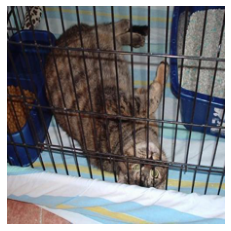

Done


In [8]:
# Images that predicted wrong:

def move_file(image_path):
        # Move wrong predicted images to separated folder
        file_name=os.path.basename(image_path)
        cls_name=os.path.basename(os.path.dirname(image_path))

        source_path=os.path.join(training_data_directory, 'processed', cls_name, file_name)
        target_path=os.path.join(training_data_directory, 'wrong', cls_name);
        target_name=os.path.join(target_path, file_name)

        try:
            if not os.path.exists(target_path):
                os.makedirs(target_path)
            
            os.rename(source_path, target_name)
        except FileNotFoundError as exc:
            print(str(exc))

preview=True
limit=10
skip=0
for idx, expected in enumerate(y_test):
    result = y_pred[idx]
    if (result != expected):
        if preview:
            if skip > 0:
                skip -= 1
                continue

            print('{} -> {}: {:.2f}%'.format(
                os.path.basename(image_paths[idx]),
                class_names[result],
                predictions[idx][result] * 100
            ))
            plt.imshow(x_test[idx])
            plt.axis('off')
            plt.show()
            limit -= 1
            if (limit < 1):
                break
        else:
            move_file(image_paths[idx])

print('Done')

end.